# 0 - Using pycoco to Generate Lightcurves
___
CoCo is a tool to generate Core-Collapse Supernova lightcurves using spectrophotometric templates, based on a sample of 30 Stripped-Envelope SNe. This set of notebooks (and module) basically assume that you have this installed - if not, head to [https://github.com/UoS-SNe/CoCo](https://github.com/UoS-SNe/CoCo) and follow the instructions.

## Brief description of operation
___
![flowchart](data/pycoco_flowchart.png)

## Prerequisites
___
There are three environment variables you need to have set before `pycoco` will work properly:

* `COCO_ROOT_DIR` (my default is `${HOME}/Code/CoCo/`)
* `SFD_DIR` (this points to dust maps for extincting simulations - my default is `${HOME}/data/Dust/sfddata-master/` - see https://github.com/kbarbary/sfdmap for detailed instructions, including where to download the maps)
* `LSST_THROUGHPUTS`  (my default is `${HOME}/projects/LSST/throughputs` - this needs to point at a clone of [https://github.com/lsst/throughputs](https://github.com/lsst/throughputs)) 


The `CoCo` cython simulation module also needs to be built. Run:

```python setup.py build_ext --inplace```

_note_: `COCO_ROOT_DIR` should also be in your path 

This creates the module `pyCoCo` (_note caps_) which I'll be importing as `pccsims`. 

## Testing `pycoco`

Assuming you have done the above, you can check the install by running the bundled tests:

test_BaseSpectrumClass_get_list_dir_returns_default (pycoco.testing.TestClass) ... ok
test_COCO_ROOT_DIR_environment_variable_exists (pycoco.testing.TestClass) ... ok
test_COCO_ROOT_DIR_exists (pycoco.testing.TestClass) ... ok
test_LSST_THROUGHPUTS_BASELINE_DIR_exists (pycoco.testing.TestClass) ... ok
test_LSST_THROUGHPUTS_DIR_exists (pycoco.testing.TestClass) ... ok
test_LSST_THROUGHPUTS_environment_variable_exists (pycoco.testing.TestClass) ... ok
test_PYCOCO_DATA_DIR_exists (pycoco.testing.TestClass) ... ok
test_PYCOCO_FILTER_DIR_exists (pycoco.testing.TestClass) ... ok
test_PhotometryClass_1993J_phot_size (pycoco.testing.TestClass) ... 

Running test suite:



FAIL
test_PhotometryClass_get_1993J (pycoco.testing.TestClass) ... ok
test_PhotometryClass_get_and_plot_1993J (pycoco.testing.TestClass) ... ok
test_PhotometryClass_get_data_dir_returns_default (pycoco.testing.TestClass) ... ok
test_SFD_DIR_environment_variable_exists (pycoco.testing.TestClass) ... ok
test_SFD_DIR_exists (pycoco.testing.TestClass) ... ok
test_SpectrumClass_get_data_dir_returns_default (pycoco.testing.TestClass) ... ok
test_SpectrumClass_get_specphot_works_with_many_requested_and_many_overlapping_filters (pycoco.testing.TestClass) ... ok
test_SpectrumClass_get_specphot_works_with_one_requested_and_many_overlapping_filters (pycoco.testing.TestClass) ... ok
test_SpectrumClass_get_specphot_works_with_one_requested_and_one_overlapping_filter (pycoco.testing.TestClass) ... ok
test_check_dir_path_finds_pycoco_dir (pycoco.testing.TestClass) ... ok
test_check_dir_path_raises_PathError_for_None (pycoco.testing.TestClass) ... ok
test_check_dir_path_raises_PathError_for_file (pyco

SN2011bm.list  passed
SN2008bo.list  passed
SN2009iz.list  passed
SN2011fu.list  passed
SN2005bf.list  passed
SN2007C.list  passed
SN1996cb.list  passed
SN2007gr.list  passed
SN2002ap.list  passed
SN1998bw.list  passed
SN2012ap.list  passed
SN2009er.list  passed
SN2004aw.list  passed
SN2003jd.list  passed
SN1994I.list  passed
SN2008ax.list  passed
SN2011dh.list  passed
SN2007uy.list  passed
SN2009bb.list  passed
SN2005hg.list  passed
SN2007Y.list  passed


ERROR
test_dark_sky_spectrum_exists (pycoco.testing.TestClass) ... ok
test_filter_LSST_filters_load (pycoco.testing.TestClass) ... 

/Users/szymon/Projects/throughputs/baseline/darksky.dat
file exists? True
loading LSST_u
from /Users/szymon/Projects/CoCo/data/filters/LSST_u.dat
file exists?  True
loading LSST_g
from /Users/szymon/Projects/CoCo/data/filters/LSST_g.dat
file exists?  True
loading LSST_r
from /Users/szymon/Projects/CoCo/data/filters/LSST_r.dat
file exists?  True
loading LSST_i
from /Users/szymon/Projects/CoCo/data/filters/LSST_i.dat
file exists?  True
loading LSST_z
from /Users/szymon/Projects/CoCo/data/filters/LSST_z.dat
file exists?  True
loading LSST_y
from /Users/szymon/Projects/CoCo/data/filters/LSST_y.dat
file exists?  True


ok
test_filter_default_colour (pycoco.testing.TestClass) ... ok
test_filter_default_frequency_units (pycoco.testing.TestClass) ... ok
test_filter_default_wavelength_units (pycoco.testing.TestClass) ... ok
test_filter_edge_calc (pycoco.testing.TestClass) ... ok
test_filter_name_parsed_OK (pycoco.testing.TestClass) ... ok
test_find_filter_phot_finds_no_SN2011fe_data (pycoco.testing.TestClass) ... /Users/szymon/anaconda/lib/python3.5/site-packages/pycocosn-0.9.19-py3.5.egg/pycoco/functions.py:254: UserWarning: No matches found.
  warnings.warn("No matches found.")
ok
test_find_formatted_phot_finds_SN2005bf (pycoco.testing.TestClass) ... /Users/szymon/anaconda/lib/python3.5/site-packages/pycocosn-0.9.19-py3.5.egg/pycoco/functions.py:314: UserWarning: Found /Users/szymon/Projects/CoCo/data/lc/SN2005bf.dat - you could just read that in.
  warnings.warn("Found " + os.path.join(path,snname + file_type) + " - you could just read that in.")
ok
test_find_formatted_phot_finds_no_SN2011fe_data (pyc

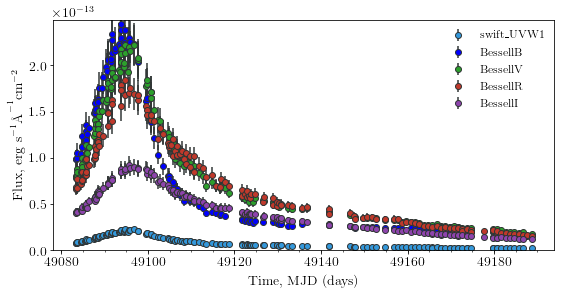

In [34]:
import pycoco as pcc

pcc.testing.runtests()

# Simulating Lightcurves
___
This section deals with simulating lightcurves - hopefully you have the bundled fits, or have run your own (if not, now is a good time to head over to [1 - pycoco calling CoCo.ipynb](1 - pycoco calling CoCo.ipynb)).

Below is a minumum working example. Following on from that is a more realistic treatment using a subset of LSST OpSim simulations.

In [35]:
%matplotlib inline

from matplotlib import pyplot as plt

import os
import numpy as np

import pycoco as pcc
import pyCoCo as pccsim

## Set up the Simulator Generator
___

In [36]:
fltPath = pcc.utils.b(pcc.defaults._default_filter_dir_path)
rootPath = pcc.utils.b(pcc.defaults._default_coco_dir_path)
print(fltPath)
print(rootPath)

info = pcc.classes.InfoClass()
info.load()

coco = pccsim.pyCoCo(fltPath, rootPath)

b'/Users/szymon/Projects/CoCo/data/filters/'
b'/Users/szymon/Projects/CoCo/'


# Simple LC
___
## Set Params

In [43]:
snname = "SN1998bw"             ## Name of the SN Template to use
mjdmax = 50.                    ## Time that peak set by specphase() occurs at
mjd_obs = np.arange(0.,105.,5.) ## 5 Day Cadence, single filter

filter_name = "BessellV"
filter_obs = np.array([pcc.utils.b(filter_name) for observation in mjd_obs]) ## bytestrings
                                                                             
z_sim = info.get_sn_info(snname)["z_distmod"]

absmag_offset = 0.0
EBV_MW = 0.0
EBV_host = 0.0
R_v = 3.1

## Generate Lightcurve

In [44]:
flux, flux_err = coco.simulate(pcc.utils.b(snname),
                               z_sim, 
                               absmag_offset, 
                               EBV_MW, EBV_host, R_v,
                               mjdmax, mjd_obs,
                               filter_obs)

## Load in and Inspect

In [45]:
sn_sim = pcc.classes.SNClass("SN1998bw")
sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_obs, flux, flux_err, filter_obs))
sn_sim.phot.data

OrderedDict([('BessellV', <Table length=21>
                MJD          flux       flux_err  filter 
              float64      float64      float64    str8  
              ------- ----------------- -------- --------
                  0.0  6.2936941139e-20      0.0 BessellV
                  5.0 2.53843660456e-19      0.0 BessellV
                 10.0 1.02382355675e-18      0.0 BessellV
                 15.0 4.12927485664e-18      0.0 BessellV
                 20.0 1.66520756878e-17      0.0 BessellV
                 25.0 6.71079637443e-17      0.0 BessellV
                 30.0 2.69488692307e-16      0.0 BessellV
                 35.0 1.06221903273e-15      0.0 BessellV
                 40.0 3.82011002014e-15      0.0 BessellV
                 45.0 9.75800367552e-15      0.0 BessellV
                 50.0  1.3298025865e-14      0.0 BessellV
                 55.0 1.18177683379e-14      0.0 BessellV
                 60.0 9.22537430683e-15      0.0 BessellV
                 65.0 7.0074

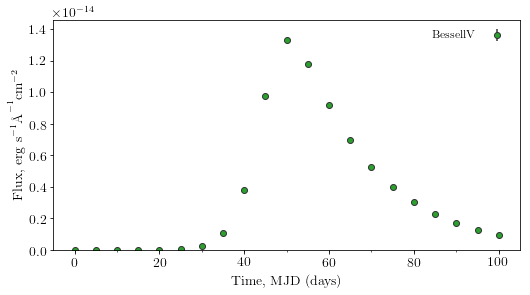

In [46]:
sn_sim.plot_lc(multiplot = False)

## Let's Compare

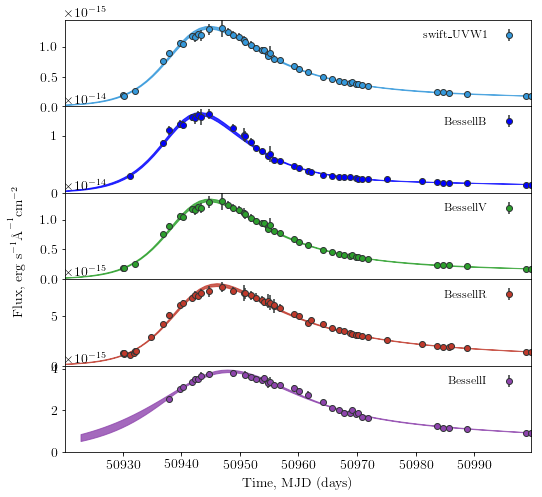

In [47]:
sn = pcc.classes.SNClass(snname)
sn.load_phot(verbose=False)
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))

sn.plot_lc(multiplot=True)

/Users/szymon/anaconda/lib/python3.5/site-packages/pycocosn-0.9.19-py3.5.egg/pycoco/classes.py:2947: UserWarning: Returning figure, saveargs will be ignored
  warnings.warn("Returning figure, saveargs will be ignored")


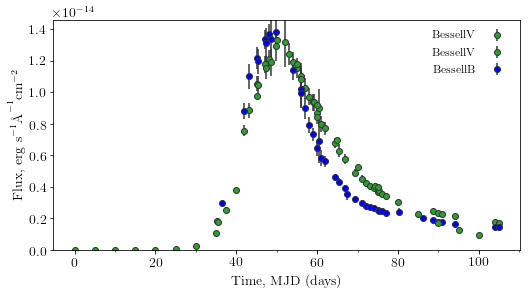

In [48]:
mjdmax_bessellV = pcc.utils.get_mjdmax(sn, "BessellV")

fig = sn_sim.plot_lc(multiplot = False, return_figure=True)

ax = fig.add_subplot(111)
ax.errorbar(sn.phot.data["BessellV"]["MJD"] - mjdmax_bessellV + 50, sn.phot.data["BessellV"]["flux"],
            yerr = sn.phot.data["BessellV"]["flux_err"], capsize = 0, fmt = 'o',
            color = pcc.colours.hex["BessellV"], ecolor = pcc.colours.hex['batman'], mec = pcc.colours.hex["batman"],
            zorder = -99, label=r"$\rm{BessellV}$")
ax.errorbar(sn.phot.data["BessellB"]["MJD"] - mjdmax_bessellV + 50, sn.phot.data["BessellB"]["flux"],
            yerr = sn.phot.data["BessellB"]["flux_err"], capsize = 0, fmt = 'o',
            color = pcc.colours.hex["BessellB"], ecolor = pcc.colours.hex['batman'], mec = pcc.colours.hex["batman"],
            zorder = -99, label=r"$\rm{BessellB}$")
legend = ax.legend(loc = 'upper right', scatterpoints = 1, markerfirst = False,
                                              numpoints = 1, frameon = False, bbox_to_anchor=(1., 1.),
                                              fontsize = 12.)

# LSST-like LC
___

Rather than making a single band light curve that is sampled every 5 days, you probably want to simulate a realistic cadence, in more than one band. Luckily, there is an example for that too.

## Deep Drilling Fields

In [ ]:
from astropy.table import Table

ddf_opsimpath = "data/ddf_opsimdf_fieldID2786_minion.csv"
# ddf_opsimpath = "data/ddf_opsimdf_fieldID2786_fakerolling.csv"

t = Table.read(ddf_opsimpath)

In [ ]:
t[:5]

In [ ]:
w = np.where(t["night"] < 356)

t_y1 = t[w] ## just consider the first year

In [ ]:
snname = "SN1998bw"             ## Name of the SN Template to use
mjdmax = 90                     ## Time that peak set by specphase() occurs at, relative to the first observation
mjd_obs = t_y1["expMJD"]-np.nanmin(t_y1["expMJD"])
                                                                                        ## The filters must be a np array of
filter_obs = np.array([pcc.utils.b("LSST_"+filter_name) for filter_name in t_y1["filter"]]) ## bytestrings
                                                                             
z_sim = info.get_sn_info(snname)["z_distmod"] ## simulate at the same redshift as before

absmag_offset = 0.0
EBV_MW = 0.0
EBV_host = 0.0
R_v = 3.1

In [ ]:
flux, flux_err = coco.simulate(pcc.utils.b(snname),
                               z_sim, 
                               absmag_offset, 
                               EBV_MW, EBV_host, R_v,
                               mjdmax, mjd_obs,
                               filter_obs)

In [ ]:
sn_sim = pcc.classes.SNClass("SN1998bw")
sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_obs, flux, flux_err, filter_obs))
sn_sim.phot.data

In [ ]:
sn_sim.plot_lc()

## Wide-Fast-Deep Fields
___

In [ ]:
from astropy.table import Table

ddf_opsimpath = "data/wfd_opsimdf_fieldID1000_minion.csv"
# ddf_opsimpath = "data/wfd_opsimdf_fieldID1000_fakerolling.csv"


t = Table.read(ddf_opsimpath)

In [ ]:
t[:5]

In [ ]:
w = np.where(t["night"] < 356)

t_y1 = t[w] ## just consider the first year

In [ ]:
snname = "SN1998bw"             ## Name of the SN Template to use
mjdmax = 90                     ## Time that peak set by specphase() occurs at, relative to the first observation
mjd_obs = t_y1["expMJD"]-np.nanmin(t_y1["expMJD"])
                                                                                        ## The filters must be a np array of
filter_obs = np.array([pcc.utils.b("LSST_"+filter_name) for filter_name in t_y1["filter"]]) ## bytestrings
                                                                             
z_sim = info.get_sn_info(snname)["z_distmod"] ## simulate at the same redshift as before

absmag_offset = 0.0
EBV_MW = 0.0
EBV_host = 0.0
R_v = 3.1

In [ ]:
flux, flux_err = coco.simulate(pcc.utils.b(snname),
                               z_sim, 
                               absmag_offset, 
                               EBV_MW, EBV_host, R_v,
                               mjdmax, mjd_obs,
                               filter_obs)

In [ ]:
sn_sim = pcc.classes.SNClass("SN1998bw")
sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_obs, flux, flux_err, filter_obs))
sn_sim.phot.data

In [ ]:
sn_sim.plot_lc()

## Exporting
____

You can take a bit more of a look at the PhotometryClass and SNClass in [./3 - pycoco_SNClass.ipynb](./3 - pycoco_SNClass.ipynb)[]()